In [1]:
import os
import time
import glob

import pandas as pd
import numpy as np
import scipy.linalg
import sklearn.metrics
from PIL import Image
import gist

#visualize
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("ticks")

# Extract Gist Features

## check an image
 - `../data/sample_imgs/` has 50 random images of the blue car.

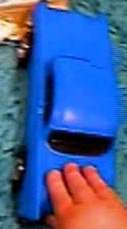

In [2]:
img_root = "../data/sample_imgs/"
img = Image.open(os.path.join(img_root,os.listdir(img_root)[20]))
img

## extract the gist feature for the image above

- https://github.com/tuttieee/lear-gist-python
```
gist.extract(img, nblocks=4, orientations_per_scale=(8, 8, 4))
    img: A numpy array (an instance of numpy.ndarray) which contains an image and whose shape is (height, width, 3).
    nblocks: Use a grid of nblocks * nblocks cells.
    orientations_per_scale: Use len(orientations_per_scale) scales and compute orientations_per_scale[i] orientations for i-th scale.
```

each image has 960 dim feature vector. *It's important to resize the image into the same size for all images.*

In [26]:
feat = gist.extract(np.array(img.resize((64,64))))
feat.shape

(960,)

## Extract GIST feature for all 50 images. 

Let's extract the feature vector for all the 50 images and keep it in a matrix X where X.shape = (50,960).


Again, *It's important to resize the image into the same size for all images.*

In [18]:
X = []
img_paths = glob.glob(os.path.join("../data/sample_imgs/","*.jpg"))
for i,path in enumerate(img_paths):
    img = Image.open(path).resize((64,64))
    feat = gist.extract(np.array(img))
    X.append(feat)
X = np.array(X)
X.shape

(50, 960)

# Apply MDS to make 2d vectors

MDS is a dimension reduction technique. The matrix $X \in \mathcal{R}^{(N,d)}$ will be transformed into $X_k \in \mathcal{R}^{(N,k)}$  where $ k << d$. In this example, N = 50, k = 2. 

I just implemented the following form taken from wikipedia: https://en.wikipedia.org/wiki/Multidimensional_scaling

 Classical MDS uses the fact that the coordinate matrix $X$ can be derived by eigendecomposition  from $B=XX'$. And the matrix $B$ can be computed from proximity matrix $D$ by using double centering.

1. Set up the squared proximity matrix $D^{(2)}=[d_{ij}^2]$
2. Apply double centering: $B=-\frac{1}{2}JD^{(2)}J$ using the centering matrix $J=I-\frac{1}{n}11'$ where $n$ is the number of objects.
3. Determine the $m$ largest eigenvalues $ \lambda_1,\lambda_2,...,\lambda_m$ and corresponding eigenvectors $e_1,e_2,...,e_m$ of $B$ (where $m$ is the number of dimensions desired for the output).
4. Now, $X=E_m\Lambda_m^{1/2}$ , where $E_m$is the matrix of $m$ eigenvectors and $\Lambda_m$ is the diagonal matrix of $m$ eigenvalues of $B$.

Classical MDS assumes Euclidean distances. So this is not applicable for direct dissimilarity ratings.

In [5]:
def reduce_dim(features,truncate=None,random_seed=0,pure_solver=False):
    #truncate should be decided by checking the histgram. should be max_dist**2
    print("random seed:",random_seed)
    print("features num x dim:",features.shape)
    print("starting classic MDS")
    print("computing pairwise distances")
    start = time.time()
    #**squared** euclidean distance
    D = sklearn.metrics.pairwise_distances(features,metric="sqeuclidean",n_jobs = -1)
    if truncate is not None:
        D = np.clip(D,0,truncate)
    e_time = time.time() - start
    print("done","e_time:%0.2f"%(e_time/60) + "[min]")

    print("double centering")
    start = time.time()
    N = D.shape[0]
    J = np.eye(N) - np.ones((N, N)) / N # Centering matrix
    B = - 1.0/2 * J.dot(D).dot(J) # Apply double centering
    del J,D
    e_time = time.time() - start
    print("done","e_time:%0.2f"%(e_time/60) + "[min]")

    print("doing svd")
    start = time.time()
    if pure_solver:
        eigenValues, eigenVectors = scipy.linalg.eig(B)
    else:
        eigenValues, eigenVectors = scipy.linalg.eigh(B)
    del B
    #note that eigenVectors in column-wise 
    #sort by eigenValues
    idx = eigenValues.argsort()[::-1]   
    eigenValues = np.real(eigenValues[idx])
    eigenVectors = np.real(eigenVectors[:,idx])
    e_time = time.time() - start
    print("done","e_time:%0.2f"%(e_time/60) + "[min]")

    print("projecting")
    start = time.time()
    X = eigenVectors[:,0:2].dot(np.diag(np.sqrt(eigenValues[0:2])))
    e_time = time.time() - start
    print("done","e_time:%0.2f"%(e_time/60) + "[min]")

    return X

In [19]:
X_2d = reduce_dim(X)
X_2d.shape

random seed: 0
features num x dim: (50, 960)
starting classic MDS
computing pairwise distances
done e_time:0.00[min]
double centering
done e_time:0.00[min]
doing svd
done e_time:0.00[min]
projecting
done e_time:0.00[min]


(50, 2)

# Plot them

First, let's organize the 2d information into a pandas frame. Then, let's load size information stored in sample_imgs_size.csv. We also store the color information randomly. 

In [20]:
df_size = pd.read_csv("../data/sample_imgs_size.csv")
name2size = {name:size for name,size in  zip(df_size["img_name"],df_size["size"])}
df_mds = []
for i,path in enumerate(img_paths):
    img_name = os.path.basename(path)
    size = 100*name2size[img_name]
    category = "small"
    if size > 10:
        category = "large"
    row = {"img_name":img_name,'x':X_2d[i,0],'y':X_2d[i,1],'size':size,"category":category}
    df_mds.append(row)
df_mds = pd.DataFrame(df_mds)

## simply plot with dots

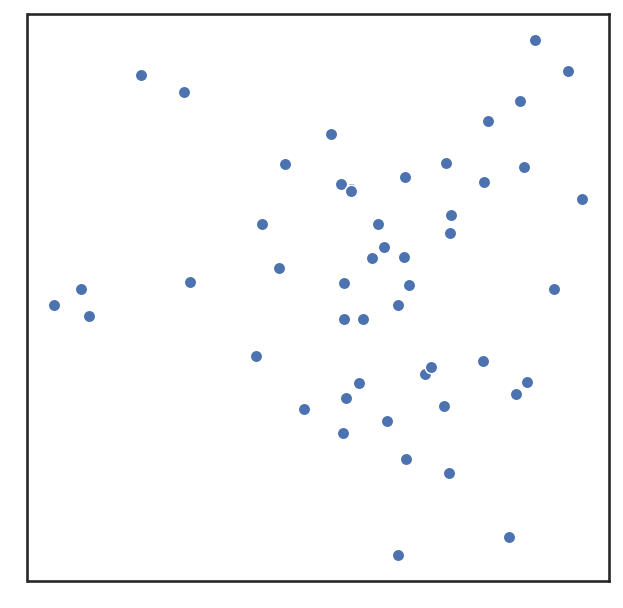

In [21]:
fig, ax = plt.subplots(1, 1,figsize=(5,5),dpi=150)
sns.scatterplot(x="x", y="y",data=df_mds,ax=ax)
ax.set_ylabel(None); ax.set_xlabel(None)
ax.set_yticks([]);ax.set_xticks([])
plt.show()

## plot with dots with size

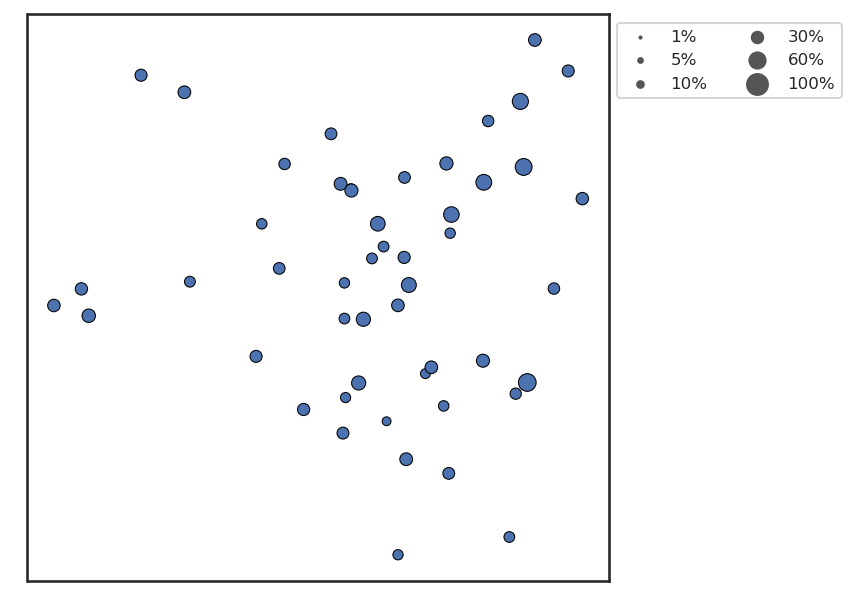

In [22]:
edgecolor= "black"
linewidth = 0.5
fontsize = 12
seize_representative = [1,5,10,30,60,100]

fig, ax = plt.subplots(1, 1,figsize=(5,5),dpi=150)
sns.scatterplot(data=df_mds,x="x", y="y",size="size",edgecolor=edgecolor,linewidth= linewidth,ax=ax)
ax.set_ylabel(None); ax.set_xlabel(None)
ax.set_yticks([]);ax.set_xticks([])

reps = []
names = []
for s in seize_representative:
    reps.append(plt.scatter([],[], s=s, marker='o', color='#555555'))
    names.append(str(s) + "%")
ax.legend(reps,
       names,
       scatterpoints=1,
       loc='upper left',
       ncol=2,
       fontsize=8,
       bbox_to_anchor=(1, 1))
plt.show()

## plot with dots with two colors (colors are random this time)

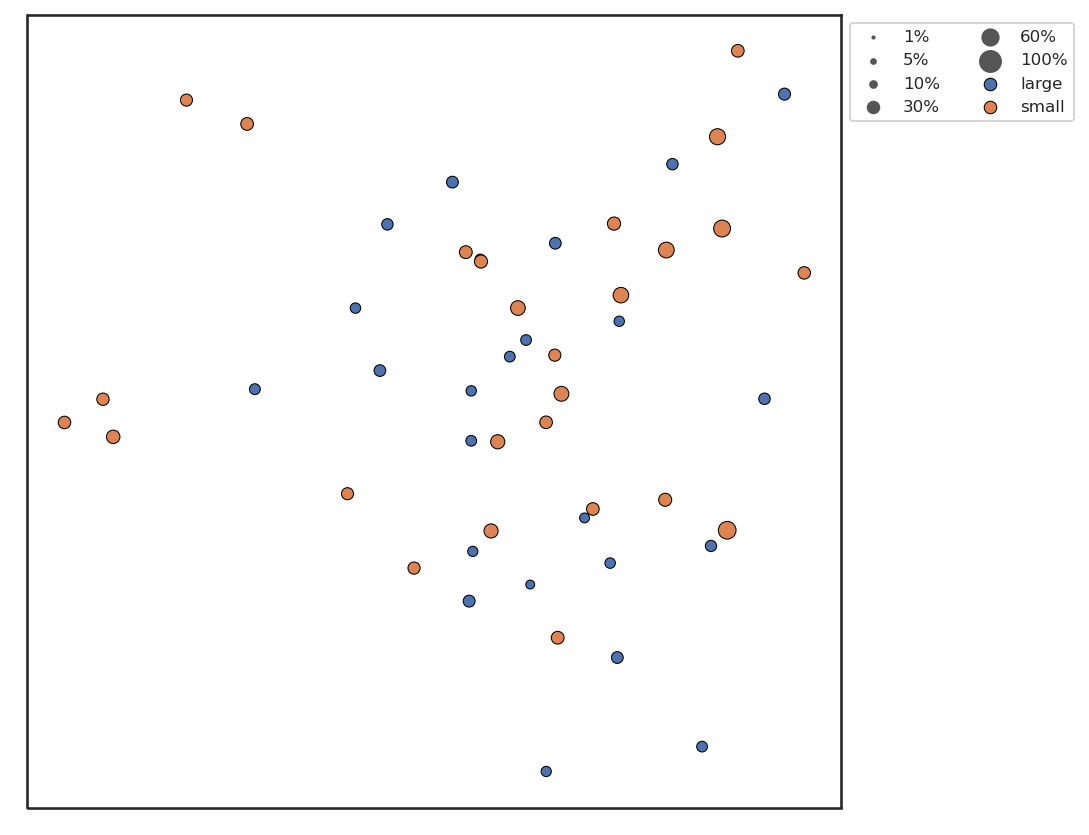

In [23]:
axis = None
seize_representative = [1,5,10,30,60,100]
hue_order = sorted(df_mds["category"].unique())
colors = [""]
edgecolor= "black"
linewidth = 0.5
fontsize = 12
fig, ax = plt.subplots(1, 1,figsize=(7,7),dpi=150)
ax = sns.scatterplot(x="x", y="y",data=df_mds,ax=ax,hue="category",size="size",
                     edgecolor=edgecolor,linewidth= linewidth)
ax.set_ylabel(None); ax.set_xlabel(None)
ax.set_yticks([]);ax.set_xticks([])

colors = sns.color_palette()
reps = []
names = []
for s in seize_representative:
    reps.append(plt.scatter([],[], s=s, marker='o', color='#555555'))
    names.append(str(s) + "%")
for j,view_ in enumerate(hue_order):
    reps.append(plt.scatter([],[], marker='o', color=colors[j],edgecolor=edgecolor,linewidth= linewidth))
    names.append(view_)
ax.legend(reps,
       names,
       scatterpoints=1,
       loc='upper left',
       ncol=2,
       fontsize=8,
       bbox_to_anchor=(1, 1))
plt.show()

## plot with real images

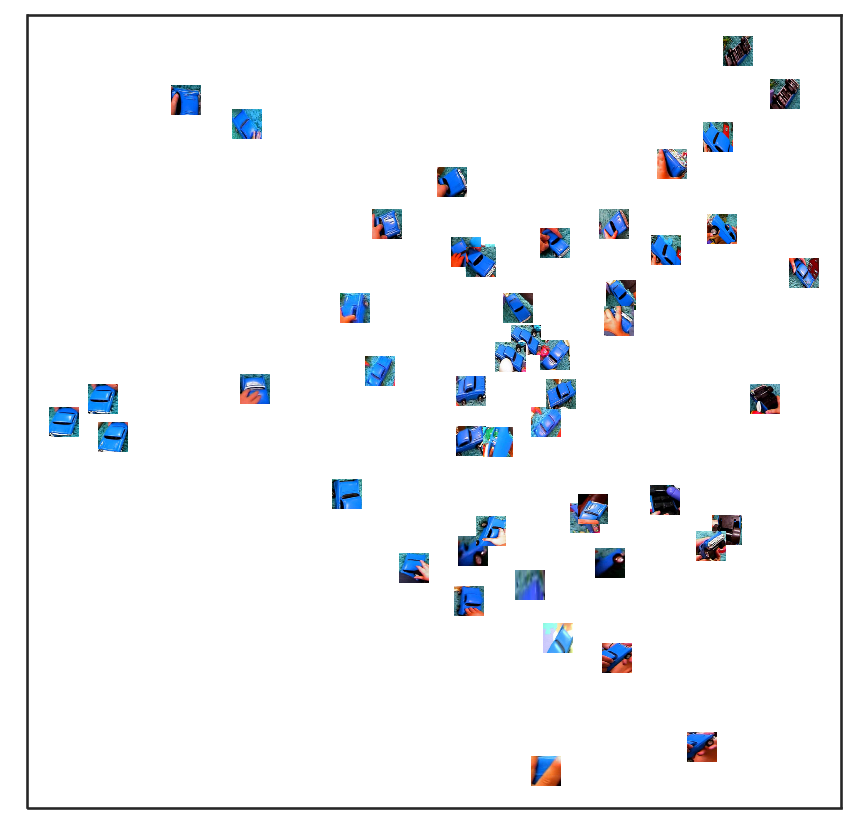

In [24]:
axis = None
resize = 72
img_scale = 0.2
edgecolor= "black"
linewidth = 0.5
fontsize = 12
fig, ax = plt.subplots(1, 1,figsize=(7,7),dpi=150)
ax.set_ylabel(None); ax.set_xlabel(None)
ax.set_yticks([]);ax.set_xticks([])

for i, (x, y) in enumerate(zip(df_mds["x"], df_mds["y"])):
    img_path = os.path.join(img_root,df_mds.loc[i]["img_name"])
    img = Image.open(img_path).resize([resize,resize])
    im = OffsetImage(img, zoom=img_scale)
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
    ax.add_artist(ab)
ax.update_datalim(np.column_stack([df_mds["x"], df_mds["y"]]))
ax.autoscale()

plt.show()